# Implied Volatility

Estoy siguiendo el ejercicio propuesto que esta en la parte de codigos del github. Hay multiples modos de generar una curva de volatilidad. Las conveniencias de cada una son discutibles para las aplicaciones practicas. En primer lugar esta curvas se calibran a los datos de mercado. Tomare una forma simple de generar la curva de volatilidad, siguiendo el video de Byrne. A medida que vaya investigando agregare otras formas

Primero, calculo los volatilidad implicita para un conjunto de datos de mercado (S,K,T,r,q)

In [2]:
import numpy as np
import pandas as pd

In [106]:
from scipy.optimize import bisect
from opcion_americana_bin import opcion_americana_bin

"""
iv
Def
    Calculador de la volatilidad implicita con el modelo del Arbol Binomial (CRR)
Inputs
    - tipo : string - Tipo de contrato entre ["C","P"]
    - S : float - Spot price del activo
    - K : float - Strike price del contrato
    - T : float - Tiempo hasta la expiracion (en años)
    - r : float - Tasa 'libre de riesgo' (anualizada)
    - sigma : float - Volatilidad implicita (anualizada)
    - div : float - Tasa de dividendos continuos (anualizada)
    - pasos : int - Cantidad de pasos del arbol binomial
    - V: float - Precio del contrato en el mkt ('C'o'P')
Outputs
    - sigma: float - IV
"""


def iv(tipo, S, K, T, r, div, pasos, V):
    try:
        f = lambda x: opcion_americana_bin(tipo,S,K,T,r,x,div,pasos) - V
        s_ = bisect(f,0.01,1.99)
        return s_
    except:
        s_= 0
        return 0

In [58]:
#test
tipo = "C"
S= 210
K= 200
T= 0.5
r= 0.3
div= 0.
pasos= 200
V=opcion_americana_bin(tipo,S, K, T, r, 0.5, div, pasos) # el sigma es 0.5

sigma_ = iv(tipo, S, K, T, r, div, pasos, V)
print(sigma_)

0.5000000000003819


# Market Data

Ahora hay que tomar datos del mercado

In [11]:
from data_nyse import *
import datetime

opciones_TSLA = obtener_panel_opciones_nyse('TSLA', True)
opciones_TSLA.head()

,Especie,Ticker,Spot,CallPut,Strike,TTM,Last,Moneyness,impliedVolatility,Bid,Ask
0,TSLA220624C00200000,TSLA,725.780029,C,200.0,2,506.14,3.628900,7.792969,526.45,527.95
1,TSLA220624P00200000,TSLA,725.780029,P,200.0,2,0.02,3.628900,3.875000,0.00,0.01
2,TSLA220624C00250000,TSLA,725.780029,C,250.0,2,463.82,2.903120,6.558107,476.55,478.10
3,TSLA220624P00250000,TSLA,725.780029,P,250.0,2,0.01,2.903120,3.250002,0.00,0.01
4,TSLA220624C00300000,TSLA,725.780029,C,300.0,2,404.87,2.419267,5.542972,426.70,428.10


In [72]:
#nota: para obtener los resultados que yo obtuve correr con este csv. Si corren el de arriba les da actualizado
opciones_TSLA = pd.read_csv('panel_tesla.csv')

In [73]:
calls_TSLA = opciones_TSLA[opciones_TSLA['CallPut']=='C']
calls_TSLA['Price'] = (calls_TSLA.Bid + calls_TSLA.Ask)/2
calls_TSLA['IV'] = np.zeros(len(calls_TSLA['Price']))
calls_TSLA.head()

<ipython-input-73-41565241b8b2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls_TSLA['Price'] = (calls_TSLA.Bid + calls_TSLA.Ask)/2
<ipython-input-73-41565241b8b2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls_TSLA['IV'] = np.zeros(len(calls_TSLA['Price']))


,Unnamed: 0,Especie,Ticker,Spot,CallPut,Strike,TTM,Last,Moneyness,impliedVolatility,Bid,Ask,Price,IV
0,0,TSLA220624C00200000,TSLA,725.780029,C,200.0,2,506.14,3.628900,7.792969,526.45,527.95,527.200,0.0
2,2,TSLA220624C00250000,TSLA,725.780029,C,250.0,2,463.82,2.903120,6.558107,476.55,478.10,477.325,0.0
4,4,TSLA220624C00300000,TSLA,725.780029,C,300.0,2,404.87,2.419267,5.542972,426.70,428.10,427.400,0.0
6,6,TSLA220624C00350000,TSLA,725.780029,C,350.0,2,367.15,2.073657,4.591801,376.25,377.95,377.100,0.0
8,8,TSLA220624C00400000,TSLA,725.780029,C,400.0,2,325.64,1.814450,3.913574,326.75,328.10,327.425,0.0


Ahora aplicamos el modelo y podemos compararlo con el IV de yf

In [74]:
TTMs = list(set(calls_TSLA.TTM.values))
TTMs.sort()
print(TTMs)

[2, 9, 16, 23, 30, 37, 58, 86, 121, 149, 177, 212, 268, 359, 450, 576, 730]


In [107]:
#Achicamos la muestra porque eran muchos
red_calls_TSLA = calls_TSLA[(calls_TSLA['TTM'] < 576) & (calls_TSLA['TTM'] > 40) ]
red_calls_TSLA=red_calls_TSLA[red_calls_TSLA['Price']>2]
red_calls_TSLA=red_calls_TSLA[(calls_TSLA['Moneyness'] < 2) & (calls_TSLA['Moneyness'] > 0.2) ]

#Nos quedamos con lo mas importante
columns = ['Spot','Strike','TTM','impliedVolatility','Price', 'IV']
red_calls_TSLA=red_calls_TSLA[columns]


<ipython-input-107-c9e179154881>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  red_calls_TSLA=red_calls_TSLA[(calls_TSLA['Moneyness'] < 2) & (calls_TSLA['Moneyness'] > 0.2) ]


In [112]:
#aplicamos la funcion de calcular la volatilidad implicita
n= len(red_calls_TSLA.Spot)

for i in range(n):
    data = red_calls_TSLA.iloc[i,:]
    tipo = 'C'
    S = data.Spot
    K = data.Strike
    T = data.TTM/360
    V = data.Price
    div=0
    r=0.036 #sacada de libor para 12 meses
    pasos = int(100)
    alpha = iv(tipo,S,K,T,r,div,pasos,V)

    red_calls_TSLA.iloc[i,-1] = alpha


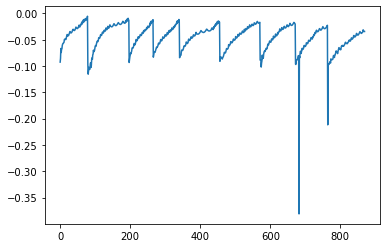

In [114]:
import matplotlib.pyplot as plt

red_calls_TSLA = red_calls_TSLA[(red_calls_TSLA['IV']!=0) &(red_calls_TSLA['impliedVolatility']!=0)]

sig_yf = red_calls_TSLA.impliedVolatility.to_numpy()
sig_bin= red_calls_TSLA.IV.to_numpy()

ratio = (sig_bin-sig_yf)/sig_bin
plt.plot(ratio)

Bueno hay diferencias como del %5 y del %10 en el valor de sigma. Con esta dependencia medio rara. 

# Volatitlity Surface

El modelo para la superfice es $\sigma = a_0 + a_{1}K+a_{2}K^2+a_{3}T+a_{4}T^2+a_{5}KT$. Esto asume hasta variaciones cuadraticas y terminos de interaccion. Notese que si todos los coeficientes menos el $a_0$ fueran cero, se estaria bajo las condiciones con las que se deriva BS (volatilidad constante en el tiempo)

In [119]:
#armamos cada columna
X = red_calls_TSLA[['Strike', 'TTM']]
X['TTM'] = X['TTM']/360
y = red_calls_TSLA['IV']

<ipython-input-119-b33849649073>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['TTM'] = X['TTM']/360


In [122]:
#Genera los vectores K^2, KT etc.
from sklearn.preprocessing import PolynomialFeatures

polyfeats = PolynomialFeatures(degree = 2, include_bias = True, interaction_only = False)

X = np.array([[X.iloc[i,0], X.iloc[i,1]] for i in range(len(X.Strike))])
X_poly = polyfeats.fit_transform(X)

In [127]:
#regresion para obtener los coeficientes de ajuste
from sklearn.linear_model import LinearRegression

reg = LinearRegression(fit_intercept = False)

reg.fit(X_poly, y)

coef = reg.coef_

In [125]:
def ivs(x,y,popt):
    a0,a1,a2,a3,a4,a5 = popt
    return a0 + a1*x + a2*y +a3*(x**2) + a4*(x*y) + a5*(y**2)

Text(0.5, 0, 'TTM')

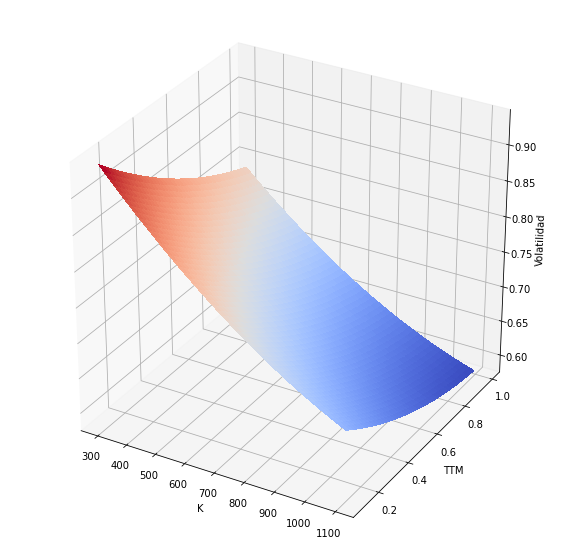

In [131]:
#Generamos la grilla arbitraria que queremos 
K = np.arange(300,1100,0.5)
T = np.arange(0.1,1,0.01)
K0, T0 = np.meshgrid(K, T)

#Evaluamos con los parametros del ajuste
Z = ivs(K0,T0,coef)


#hacemos el grafico
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
surf = ax.plot_surface(K0, T0, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_zlabel('Volatilidad')
ax.set_xlabel('K')
ax.set_ylabel('TTM')
